<a href="https://colab.research.google.com/github/AmiraBelkis/Classif_urban/blob/main/Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unet module

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D


def Unet(num_class, image_size):

    inputs = Input(shape=[image_size, image_size, 1])
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same')(conv9)
    conv10 = Conv2D(num_class, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

# Training

In [ ]:
!pip install tensorflow
import os
import cv2
import numpy as np
#from Unet import Unet
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:

def DataGenerator(file_path, batch_size):
    """
    generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen
    to ensure the transformation for image and mask is the same
    """
    aug_dict = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')
    aug_dict = dict(horizontal_flip=True,
                        fill_mode='nearest')

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        file_path,
        classes=["images"],
        color_mode = "grayscale",
        target_size = (256, 256),
        class_mode = None,
        batch_size = batch_size, seed=1)

    mask_generator = mask_datagen.flow_from_directory(
        file_path,
        classes=["labels"],
        color_mode = "grayscale",
        target_size = (256, 256),
        class_mode = None,
        batch_size = batch_size, seed=1)

    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img = img / 255.
        mask = mask / 255.
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        yield (img,mask)
trainset = DataGenerator("/content/train", batch_size=2)
print(trainset)

<generator object DataGenerator at 0x7fdd1c91d7d0>


In [ ]:

model = Unet(1, image_size=256)
trainset = DataGenerator("membrane/train", batch_size=2)
model.fit_generator(trainset,steps_per_epoch=5000,epochs=5)
model.save_weights("model.h5")

testSet = DataGenerator("membrane/test", batch_size=1)
alpha   = 0.3
model.load_weights("model.h5")
if not os.path.exists("./results"): os.mkdir("./results")

for idx, (img, mask) in enumerate(testSet):
    oring_img = img[0]
    pred_mask = model.predict(img)[0]
    pred_mask[pred_mask > 0.5] = 1
    pred_mask[pred_mask <= 0.5] = 0
    img = cv2.cvtColor(img[0], cv2.COLOR_GRAY2RGB)
    H, W, C = img.shape
    for i in range(H):
        for j in range(W):
            if pred_mask[i][j][0] <= 0.5:
                img[i][j] = (1-alpha)*img[i][j]*255 + alpha*np.array([0, 0, 255])
            else:
                img[i][j] = img[i][j]*255
    image_accuracy = np.mean(mask == pred_mask)
    image_path = "./results/pred_"+str(idx)+".png"
    print("=> accuracy: %.4f, saving %s" %(image_accuracy, image_path))
    cv2.imwrite(image_path, img)
    cv2.imwrite("./results/origin_%d.png" %idx, oring_img*255)
    if idx == 29: break

Uploading my own dataset

In [1]:
#importing from github
!git clone https://github.com/AmiraBelkis/Classif_urban.git
import sys
sys.path.append('/content/Classif_urban')

Cloning into 'Classif_urban'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 68 (delta 5), reused 30 (delta 0), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [24]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd

os.chdir('/content/Classif_urban/train/images')
os.chdir('/content/Classif_urban/train/masks')
imgs   = os.listdir('/content/Classif_urban/train/images')
masks = os.listdir('/content/Classif_urban/train/masks')

imgs.sort()
masks.sort()
print(imgs)
print(masks)

['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']


In [ ]:
y = np.zeros((9, 28,28,1), dtype=np.float32)
X = np.zeros((9,224, 224, 1), dtype=np.float32)
n = 0
for file in imgs:
  print(file)
  #index = img.index(file)
  dir_img = os.path.join('/content/Classif_urban/train/images', file)
  img = Image.open(dir_img)
  img = img.resize((224, 224))
  img = np.reshape(img.convert('L'), (224,224,1)) 
  X[n] = img
  n = n+1
n = 0
"""
for mask in masks:
  #mask = masks[index]
  dir_mask = os.path.join('/content/Classif_urban/train/masks', mask)
  mask_img = cv2.imread(dir_mask)
  #mask_img = (mask_img!=2)*1.0  
  mask_img_ = cv2.resize(mask_img, (28, 28))
  #mask_img = 1.0*(mask_img_[:,:,0]>0.2)
  #mask_img = mask_img_[:,:,0]
  y[n] = mask_img_
  n = n+1"""
for file in masks:
  print(file)
  #index = img.index(file)
  dir_img = os.path.join('/content/Classif_urban/train/masks', file)
  img = Image.open(dir_img)
  img = img.resize((28, 28))
  img = np.reshape(img.convert('L'), (28,28,1)) 
  y[n] = img
  n = n+1

In [ ]:
print(y[1])
print(type(y[1]))
print(y[1].shape)

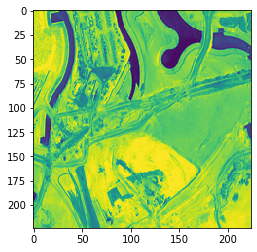

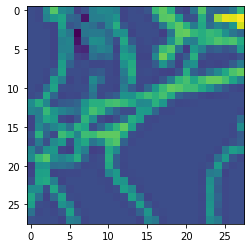

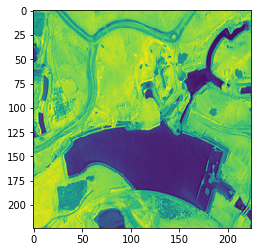

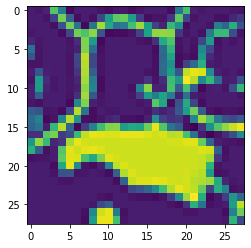

In [75]:
# displaying our training set
from matplotlib import pyplot as plt
for i in range(0,2):
  im = X[i,:,:,0]
  mask = y[i,:,:,0]
  plt.imshow(im, interpolation='nearest')
  plt.show()
  plt.imshow(mask, interpolation='nearest')
  plt.show()
  

In [107]:
"""
#!pip install git+https://github.com/qubvel/segmentation_models
!pip install segmentation_models
!git clone https://github.com/qubvel/segmentation_models.git
!pip install keras-segmentation
!pip install tensorflow==1.14
!pip install keras==2.2.4
!pip install segmentation-models==0.1.2
"""
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from keras.models import model_from_json
from keras.layers import Input, Conv2D, Reshape
from keras.models import Model

In [124]:
"""import keras 
import tensorflow.keras
print(keras.__version__)
print(tensorflow.keras.__version__)
print(tensorflow.__version__)
print(keras.optimizers)
#from keras.optimizers import Adam 
from tensorflow.keras.optimizers import Adam"""
import tensorflow as tf 
tf.optimizers.Adam()

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [129]:
from keras.layers import Reshape
N = X_train.shape[-1]
base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

input_base_model = Input(shape=(224, 224, N))

l1 = Conv2D(3, (1, 1))(inp)

out = base_model(l1)

x1 = Conv2D(10, kernel_size =3,strides=2,padding = "same", activation="relu")(out)
x1 =layers.BatchNormalization()

x2= Conv2D(10, kernel_size=3,strides=2,padding = "same", activation="relu")(x1)
x2 =layers.BatchNormalization()

x3 = Conv2D(10, kernel_size=3,strides=2,padding = "same", activation="relu")(x2)
x3 =layers.BatchNormalization()

x4 = Conv2D(1, kernel_size=2,strides=2,padding = "same", activation="relu")(x3)

x_out = Reshape((28,28))(x4)

model = Model(input_base_model, x_out, name=base_model.name)

ModuleNotFoundError: ignored

In [ ]:


model = Unet(1, image_size=256)
trainset = (train_x,train_y)
model.fit_generator(trainset,steps_per_epoch=5000,epochs=5)
model.save_weights("model.h5")

testSet = DataGenerator("/content/test", batch_size=1)
alpha   = 0.3
model.load_weights("model.h5")
#if not os.path.exists("./results"): os.mkdir("./results")

for idx, (img, mask) in enumerate(testSet):
    oring_img = img[0]
    pred_mask = model.predict(img)[0]
    pred_mask[pred_mask > 0.5] = 1
    pred_mask[pred_mask <= 0.5] = 0
    img = cv2.cvtColor(img[0], cv2.COLOR_GRAY2RGB)
    H, W, C = img.shape
    for i in range(H):
        for j in range(W):
            if pred_mask[i][j][0] <= 0.5:
                img[i][j] = (1-alpha)*img[i][j]*255 + alpha*np.array([0, 0, 255])
            else:
                img[i][j] = img[i][j]*255
    image_accuracy = np.mean(mask == pred_mask)
    image_path = "/content/results/pred_"+str(idx)+".png"
    print("=> accuracy: %.4f, saving %s" %(image_accuracy, image_path))
    cv2.imwrite(image_path, img)
    cv2.imwrite("/content/results/origin_%d.png" %idx, oring_img*255)
    if idx == 29: break